In [1]:
import cv2
import numpy as np
from PIL import Image
from pynq import allocate
from pynq import Overlay
import plotly as py
import plotly.graph_objs as go

ol = Overlay('zcu104_hep.bit')

In [2]:
# Set FPD and LPD interface widths
from pynq import MMIO
fpd_cfg = MMIO(0xfd615000, 4)
fpd_cfg.write(0, 0x00000A00)
lpd_cfg = MMIO(0xff419000, 4)
lpd_cfg.write(0, 0x00000000)

# Set the hardware speed of the system
ol.hpa_module.write(0x100, 150000000)

In [3]:
IMG_SIZE = (320,240)
THRESHOLD = 60

img = cv2.resize(cv2.imread('assets/dirtyroof.bmp'), IMG_SIZE)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sobelx = cv2.convertScaleAbs(cv2.Sobel(gray, cv2.CV_16S, 1, 0, ksize=3))
sobely = cv2.convertScaleAbs(cv2.Sobel(gray, cv2.CV_16S, 0, 1, ksize=3))

gmag = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)

ret, edge = cv2.threshold(gmag, THRESHOLD, 255, cv2.THRESH_BINARY)

image_array = np.array(edge, dtype=np.uint32)

In [4]:
from pynq import Xlnk
xlnk = Xlnk()

in_dma_array = xlnk.cma_array(shape=(IMG_SIZE[1], IMG_SIZE[0]), dtype=np.uint32)
out_dma_array = xlnk.cma_array(shape=(180, 400), dtype=np.uint32)

In [13]:
in_dma_array[:, :] = image_array[:, :]

ol.axi_dma.recvchannel.transfer(out_dma_array)
ol.axi_dma.sendchannel.transfer(in_dma_array)
ol.axi_dma.sendchannel.wait()
ol.axi_dma.recvchannel.wait()

In [6]:
ol.axi_dma.sendchannel.idle

True

In [7]:
t = ol.hpa_module.read(0x10C)
t / 150e6

0.0009920666666666667

In [8]:
def plothps(hps):
        # Plot using Plot-ly Surface API (offline mode)
        data = [go.Surface(z=hps,colorscale='Jet')]
        layout = go.Layout(
            title='Hough Parameter Space',
            autosize=False,
            width=800,
            height=800,
            scene=dict(
                yaxis=dict(
                    title='Orientation'
                ),
                xaxis=dict(
                    title='Displacement'
                ),
                zaxis=dict(
                    title='Votes'
                )
            )
        )
        fig = go.Figure(data=data, layout=layout)
        py.offline.iplot(fig)
        return fig

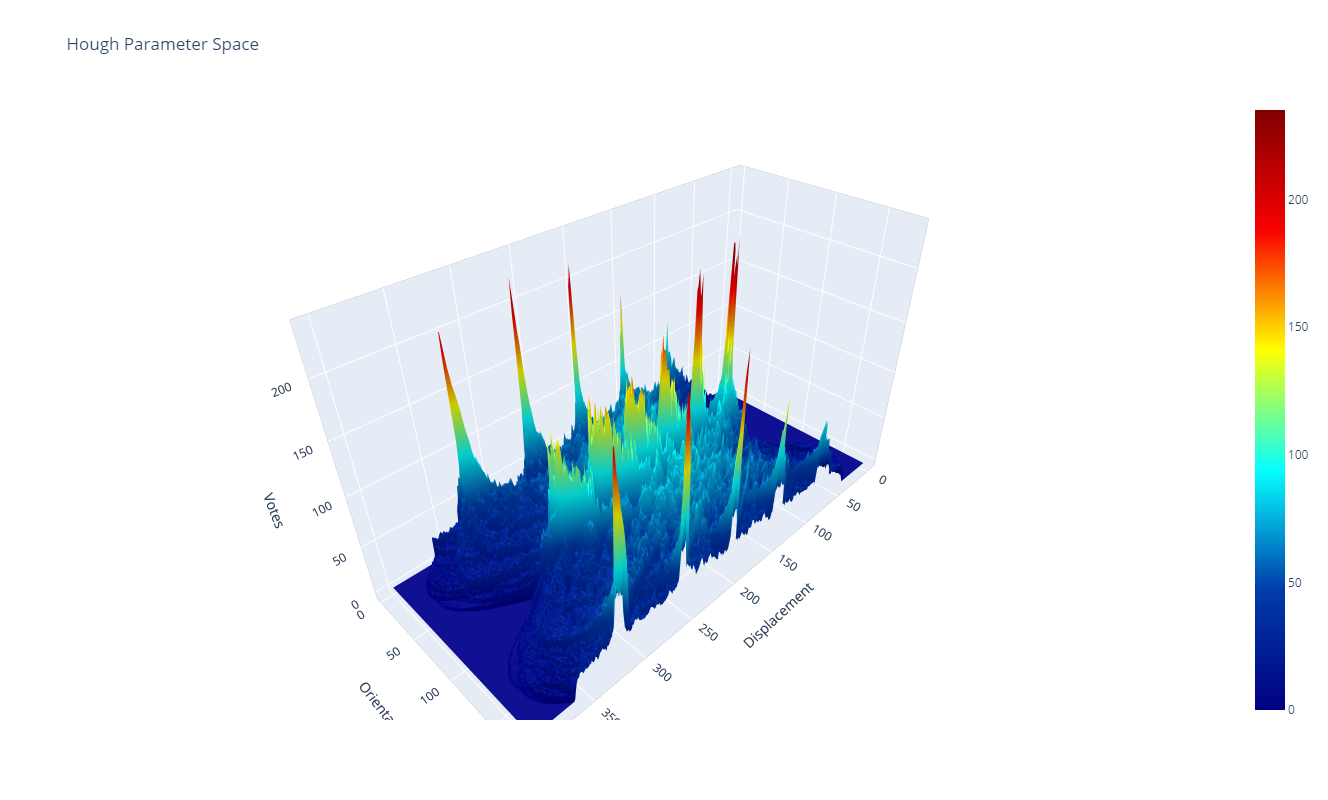

In [14]:
f = plothps(np.array(out_dma_array, dtype=np.uint32))